## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_inter_clean_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_df= pd.concat(data)

asos_snotel_df.rename(columns={'CloudCover':'CloudCover_oktas'}, inplace=True)

asos_snotel_df = asos_snotel_df.asfreq('1H')

asos_snotel_df = asos_snotel_df.interpolate(limit=3)
asos_snotel_df['Julian'] = asos_snotel_df.index.to_julian_date()

print(asos_snotel_df.head())


                     TOBS.I-1 (degC)   SNWD.I-1 (in)   Temperature_degC  \
Date_Time                                                                 
2006-01-01 01:00:00              -2.8            43.0              -1.0   
2006-01-01 02:00:00              -2.9            43.0              -3.0   
2006-01-01 03:00:00              -3.3            43.0              -4.0   
2006-01-01 04:00:00              -3.2            43.0              -4.0   
2006-01-01 05:00:00              -3.2            43.0              -5.0   

                     Dewpoint_degC  Pressure_hp  WindDirection_deg  \
Date_Time                                                            
2006-01-01 01:00:00           -7.0          NaN              220.0   
2006-01-01 02:00:00           -8.0          NaN              230.0   
2006-01-01 03:00:00           -8.0          NaN              230.0   
2006-01-01 04:00:00           -9.0          NaN              240.0   
2006-01-01 05:00:00           -8.0          NaN       

**Create a dataset which calculates the delta 12-hour snowdepth and 12-hour snowfall columns.  The delta 12-hour snowdepth contains the raw differences between snowdepth observations every 12 hours.  The 12-hour snowfall column will only include observations greater then or equal to 3 inches due to spurious nature of the snow depth measurements.  This will be useful for as snowfall is an important dependent variable **

In [3]:
fig = plt.figure(figsize=(10,5))

#Calculate 12-snowfall column by finding difference between 12-hr snow depth observations 
asos_snotel_df['12hr_SNWD_in'] = asos_snotel_df['SNWD.I-1 (in) '].resample('12H').last()
asos_snotel_df['12hr-dSNWD_in'] = asos_snotel_df['12hr_SNWD_in']-asos_snotel_df['12hr_SNWD_in'].shift(+12)
asos_snotel_df['12hr-SNOWFALL_in'] = asos_snotel_df['12hr-dSNWD_in'][asos_snotel_df['12hr-dSNWD_in']>=3]

#print(asos_snotel_df['12hr-dSNWD_in'].describe())
print(asos_snotel_df['12hr-SNOWFALL_in'].describe())


count    353.000000
mean       4.395274
std        2.092982
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       18.000000
Name: 12hr-SNOWFALL_in, dtype: float64


<Figure size 720x360 with 0 Axes>

**Do some quick timeseries plots to visually see the data:**

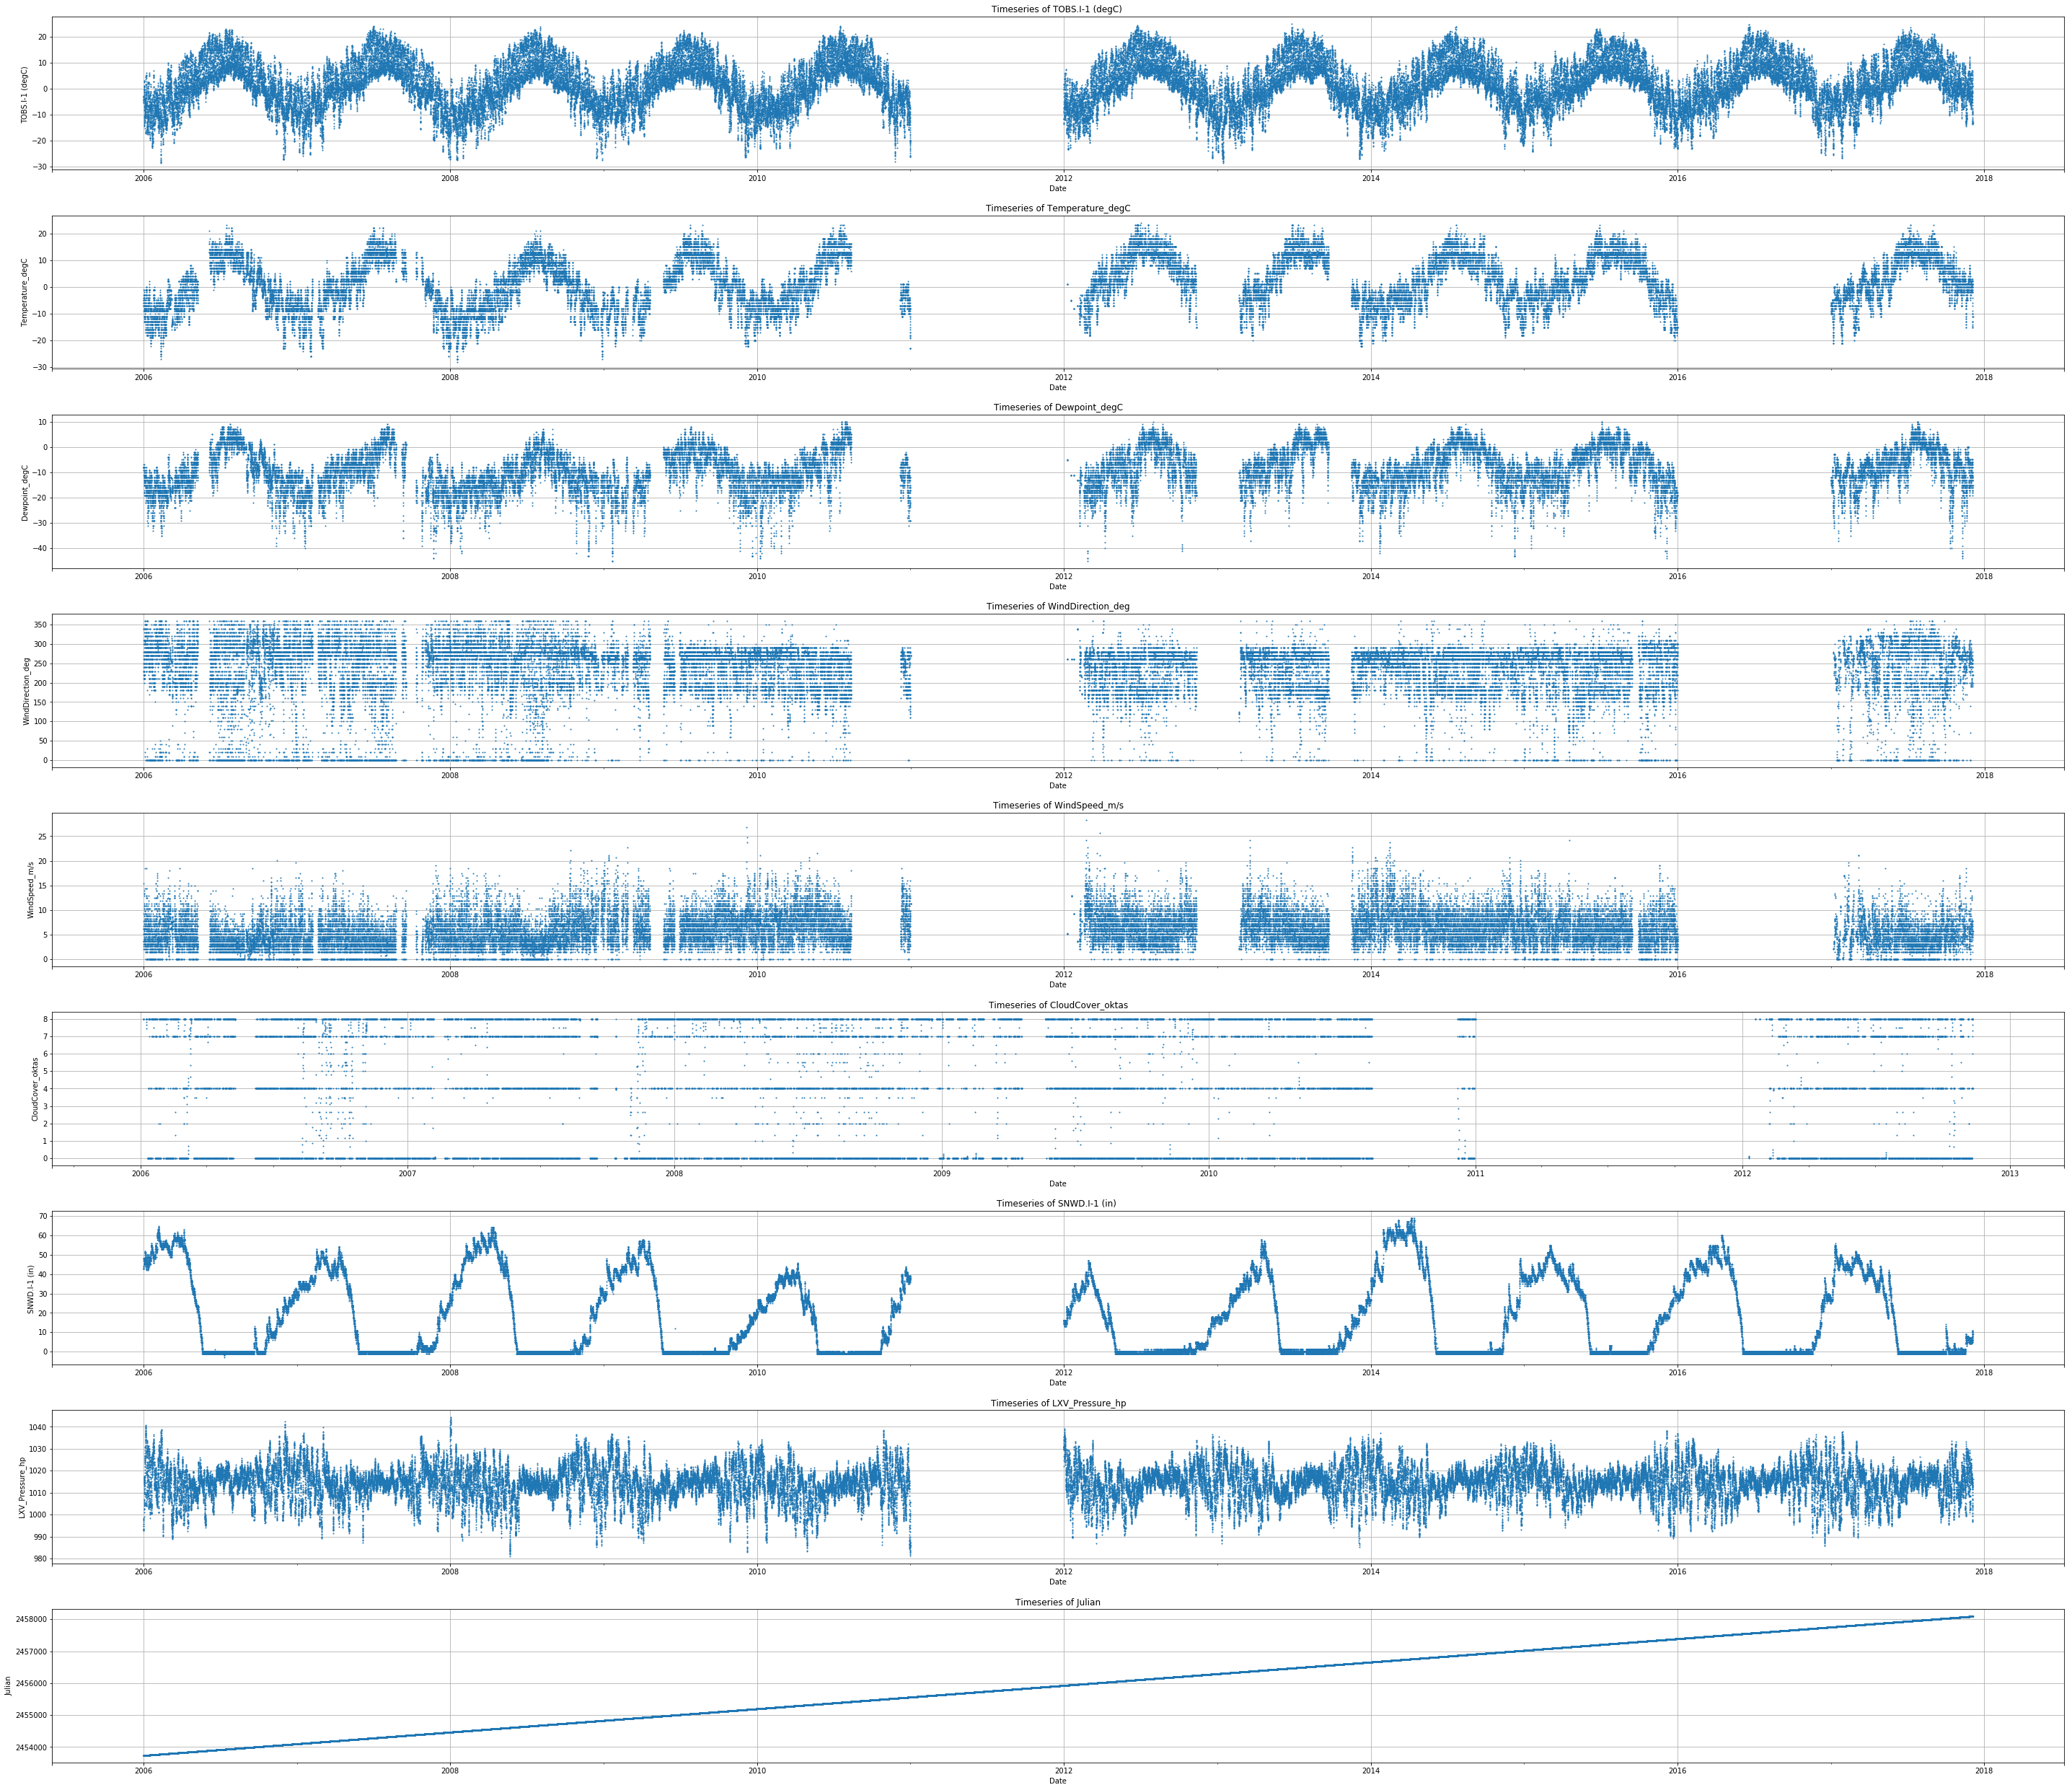

In [4]:
ax = None
%matplotlib inline
#%matplotlib notebook
keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'CloudCover_oktas', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp', 'Julian']
fig = plt.figure(figsize=(50,75))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for k in range(len(keys)):
    ax = plt.subplot(15, 1, k+1)
    asos_snotel_df[keys[k]]['2005':'2017'].plot(linestyle='None', ax = ax, marker = ".", markersize = 2)
    ax.set_xlabel("Date")
    ax.set_ylabel(keys[k])
    
    plt.title("Timeseries of " + keys[k])
 
    plt.grid()
    plt.axis('tight')
  

plt.show()



** &#8657; Some notes:  
There is a a lot of missing data for year 2011 and 2016 - this should be kept in mind as it could skew some our analyeses slightly  **



***


## Linear Regression of meteorological variables and snowfall

**Linear Regression plots were created and regression statistics were calculated using SciPy's linegress function:**

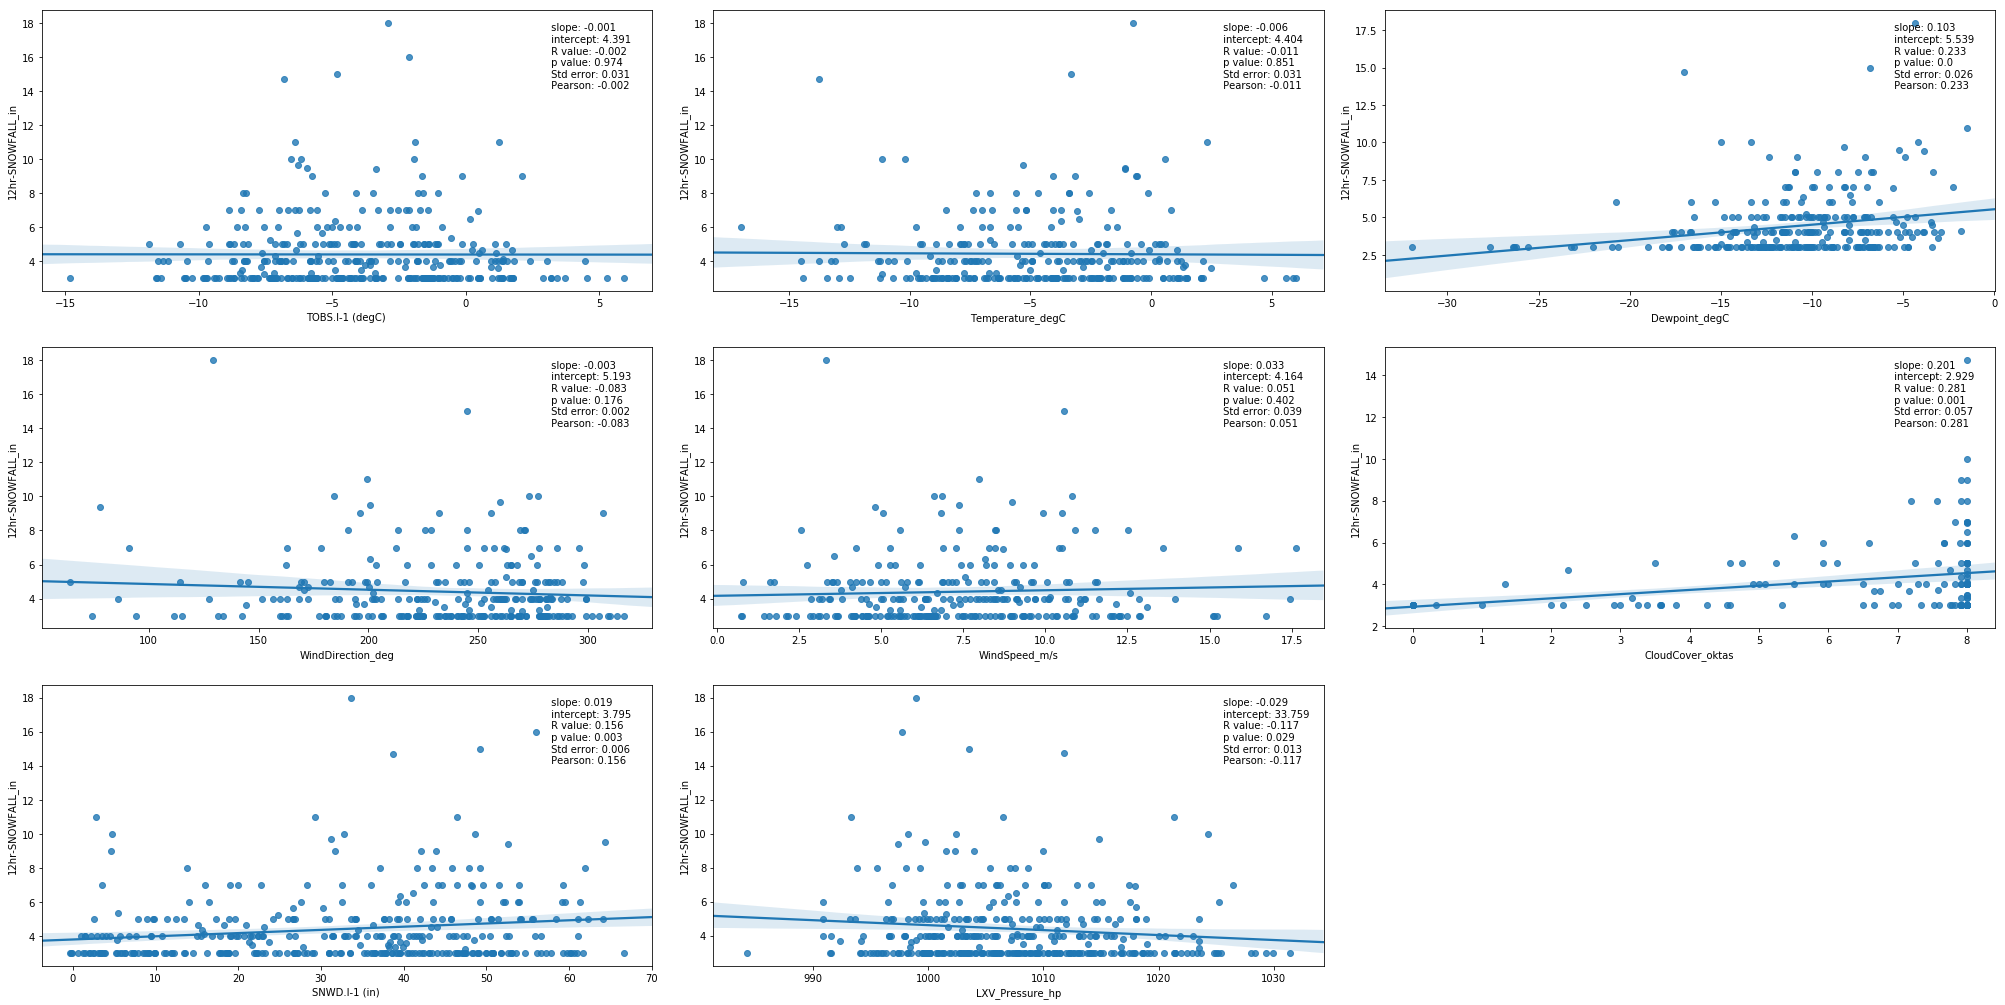

In [5]:
from scipy.stats import pearsonr, linregress
keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'CloudCover_oktas', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp']


fig = plt.figure(figsize=(35,30))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
yy = None

yy = (asos_snotel_df['12hr-SNOWFALL_in']>=3)
snf_df = asos_snotel_df['12hr-SNOWFALL_in'][yy]



for k in range(len(keys)):
    xx_df = None
    plt.subplot(5,3,k+1)

    xx_df = asos_snotel_df[keys[k]].resample('12H').mean()


    idx = np.isfinite(xx_df) & np.isfinite(snf_df)
    sns.regplot(xx_df[idx], snf_df[idx])
    
    pearson, pv = pearsonr(xx_df[idx], snf_df[idx])
    slope, intercept, r_value, p_value, std_err = linregress(xx_df[idx], snf_df[idx])
    

    plt.annotate(' slope: ' + str(round(slope,3)) +
                 '\n intercept: ' + str(round(intercept,3)) + 
                 '\n R value: ' + str(round(r_value,3)) +  
                 '\n p value: ' + str(round(p_value,3)) + 
                 '\n Std error: ' + str(round(std_err,3)) +
                 '\n Pearson: ' + str(round(pearson,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)
                                      
#    print()
#    print(str(keys[k]))
#    print('slope: '+ str(slope))
#    print('intercept:')
plt.show()




** **

**From these plots, we can see some small relationship between snowfall amounts for some meteorological variables.  **

**Note that The lineregress function tests the hypothesis that there is no relationship between tested variables (i.e. test whether the slope of the linear regression line is zero).  For Dewpoint and Pressure, we can confidently reject that hypothesis as the returned p values are less then 0.05. The p value returned for Cloud Cover was 0.052, just over 0.05 indicating fairly strong confidence as well.  Here are a few notes on each linear regression relationship for each variable:  **
* **SNOTEL Temperature (TOBS (deg C)): shows very little linear relationship with snowfall.  However, one should note there is a parabolic shape to the datapoints in the SNOTEL Temperature plot.** 
* **ASOS Temperature (Temperture_degC): same as SNOTEL Temerature.** 
* **Dewpoint: Snowfall events tend to occur at higher dewpoints, and none occur when dewpoints are greater then 0 deg C.  Physically, this would be expected as colder air cannot hold too much moisture.**
* **Wind Direction:  While there does appear to be a slight positive correlation, Wind Direction is not physically a linear measurement.  Therefore, this relationship should be applied cautiously.**  
* **Wind Speed:  Here we see a very slight positive relationship between snowfall totals and wind speed.  The Pearson coefficient is quite low here.**  
* **Cloud Cover:  Of all the variables, Cloud Cover shows the strongest relationship of all the variables (highest R value and Pearson coefficient, along with smallest p value).  This would be expected as larger snowstorms would tend to occur during extended cloudy periods.  However, this relationship should be viewed with caution as first, cloud cover is a categorical variable.  Second, cloud cover values were found to be primarily 0, 4, or 8, so there is little resolution to the data.  Also, cloud cover from years 2015-2017 were removed due to anomalous data (see outlier tab) where no the max data reported was only four. By removing these three years, the cloud cover-snowfall relationship did improve substantially.**
* **Snow Depth (SNWD) - Interestingly, there is a relationship here although physically snowdepth cannot be a variable which affects snowfall amounts.  This relationship is likely due to climatology - larger snowfall may tend to occur in March/April timeframe whenever snowpack has developed already.  This relationship could be investigated further.**  
* **Pressure:  This is another variable which appears to have a relationship with snowfall based on its p value.  Physically, one would expect higher snowfall amounts during periods of lower pressure.  This is indeed what we are seeing.  Another thing to check is pressure changes (3-hr, 24-hr, etc) to see if there is any relationship between snowfall amounts and pressure trends.**


***

## Linear Regression Transformations

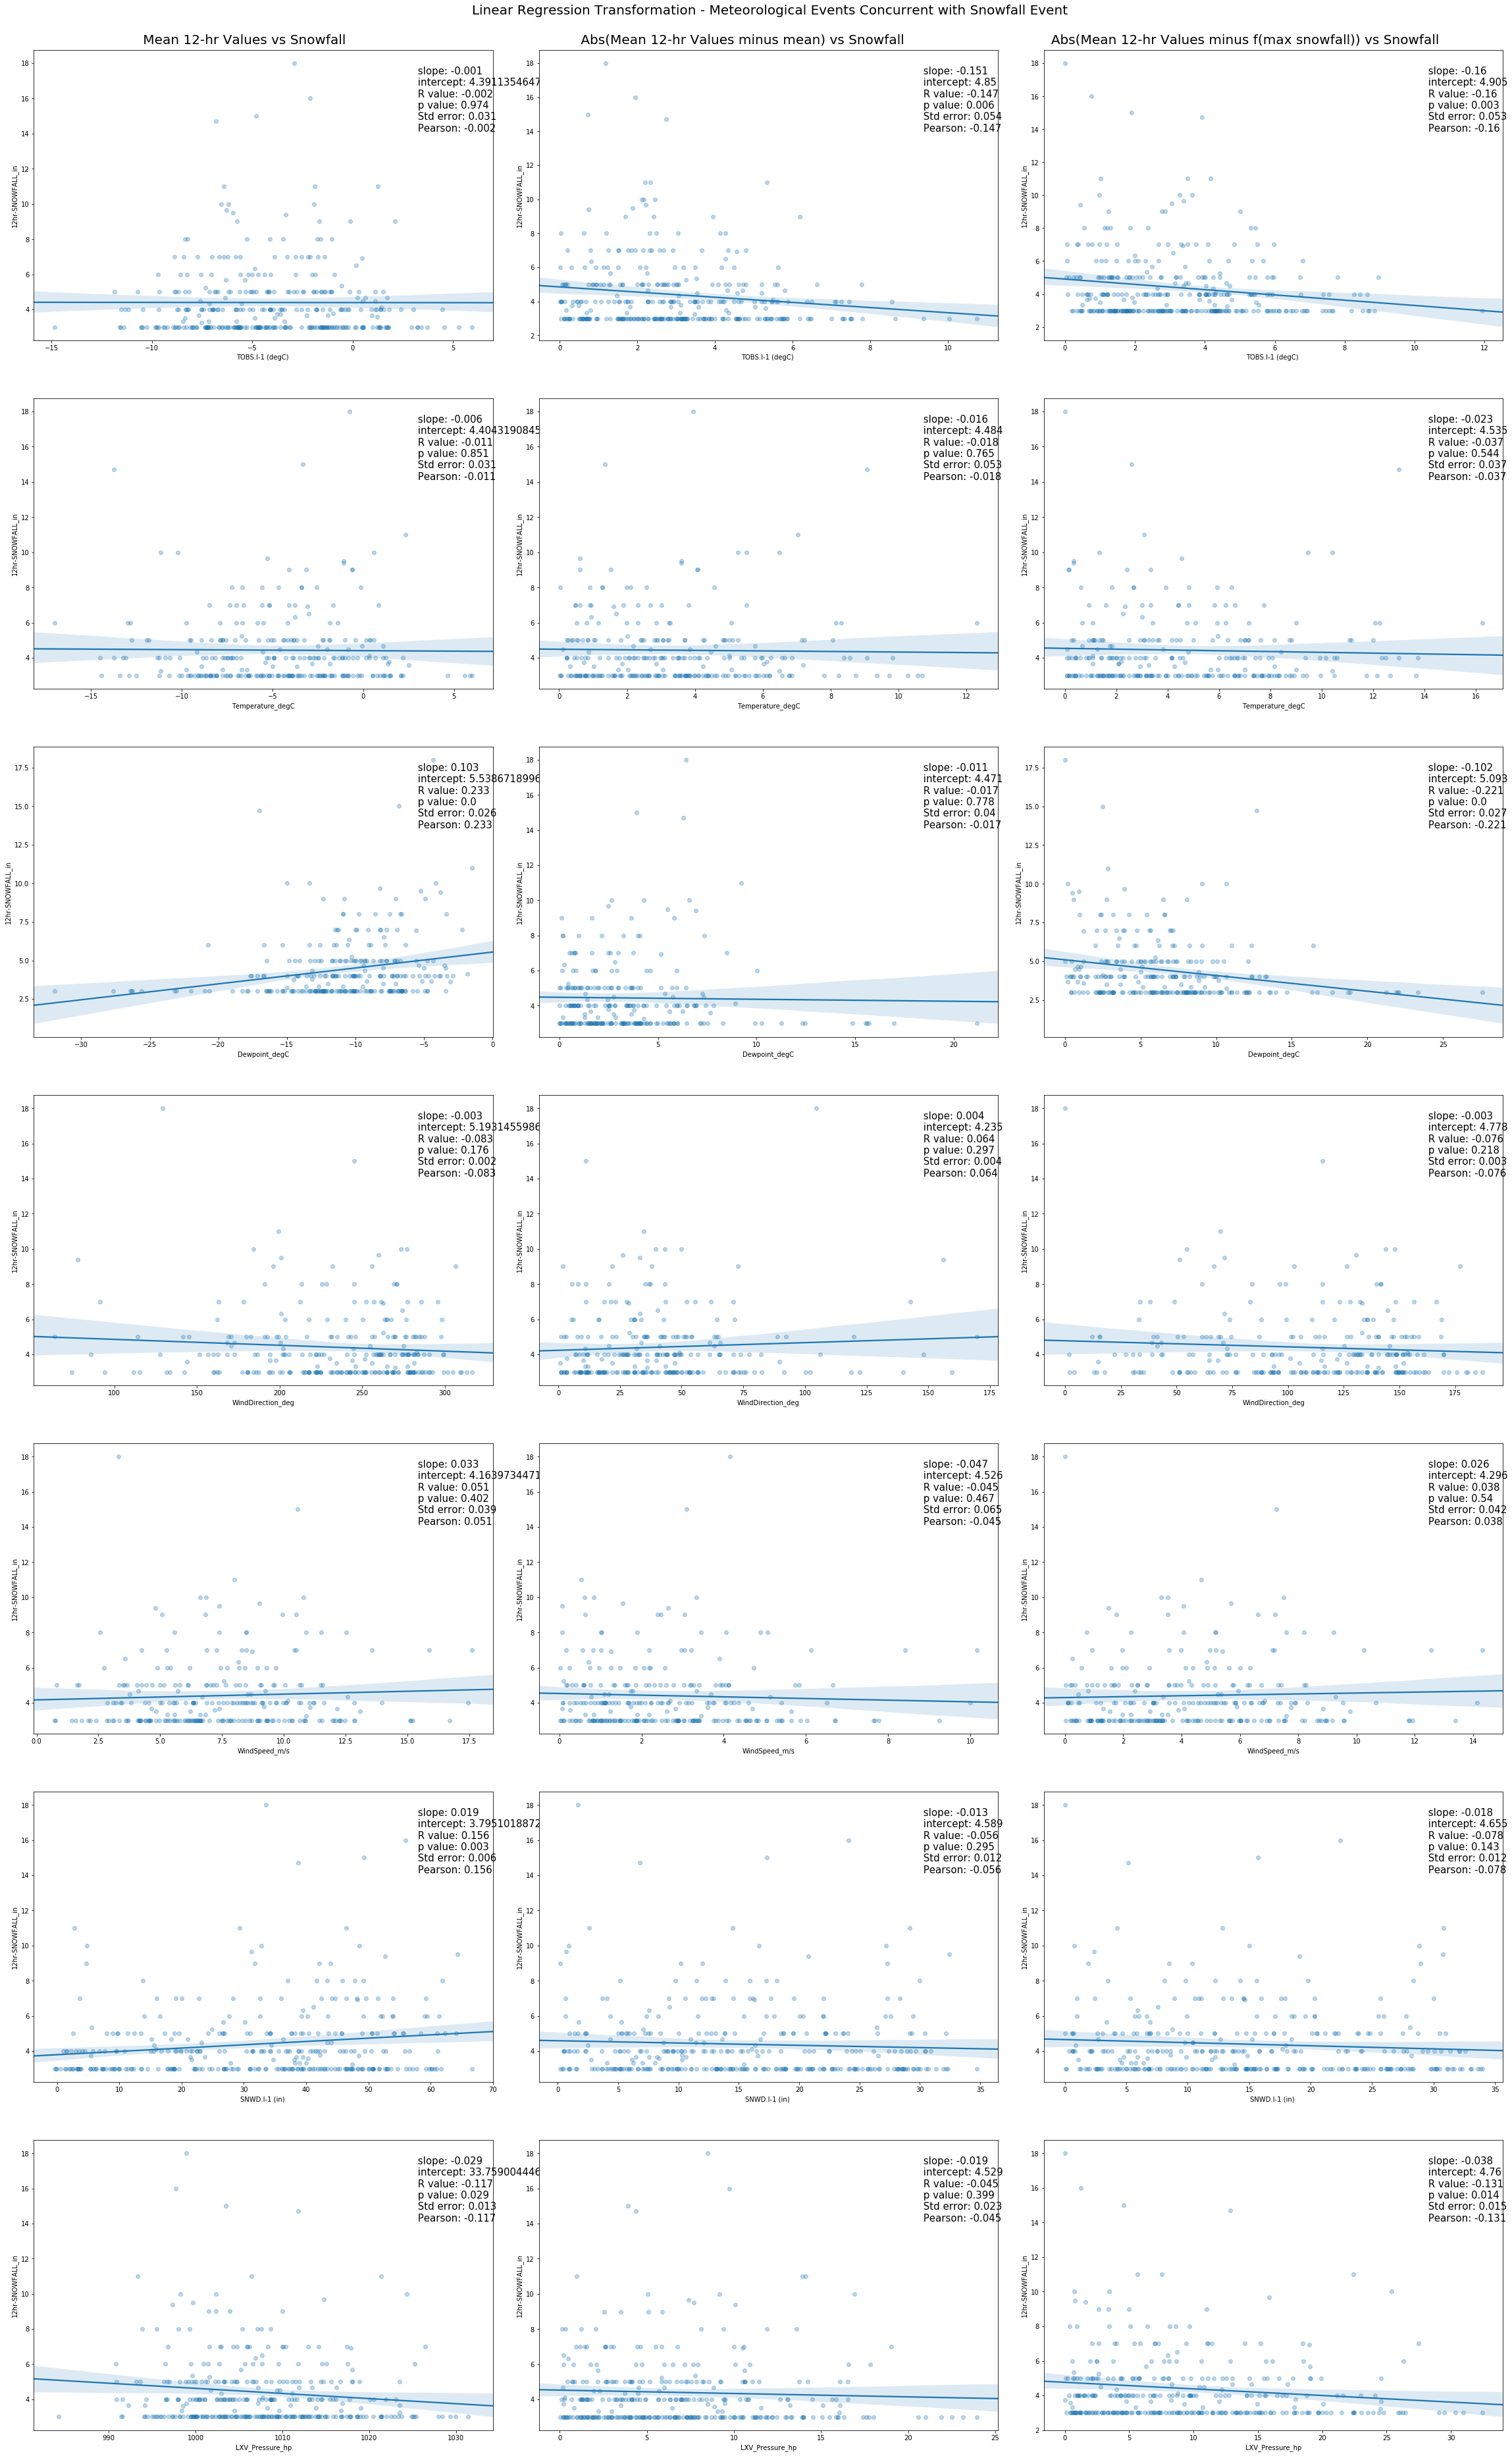

In [6]:
#shift = asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()]['TOBS.I-1 (degC) ']
#abs_diff = abs(asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()]['TOBS.I-1 (degC) ']-shift)

fig = plt.figure(figsize=(40,120))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle("%100s \n\n %50s %100s %90s" % ("Linear Regression Transformation - Meteorological Events Concurrent with Snowfall Event", "Mean 12-hr Values vs Snowfall" , "Abs(Mean 12-hr Values minus mean) vs Snowfall", "Abs(Mean 12-hr Values minus f(max snowfall)) vs Snowfall") , fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.972)



snf_df = asos_snotel_df['12hr-SNOWFALL_in'].resample('12H').last()
snf_df[snf_df<3] = np.NaN

#yy = (asos_snotel_df['12hr-SNOWFALL_in']>=3)
#snf_df = asos_snotel_df['12hr-SNOWFALL_in'][yy]

#print(snf_df)



keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp']

#keys = ['Temperature_degC']
for k in range(len(keys)):
    
    
    xx_df = None
    

    xx_df = asos_snotel_df[keys[k]].resample('12H').mean()
    
    #print(np.isnan(snf_df))
    
    subtra2_df = xx_df[~np.isnan(snf_df)].mean()
    subtra3_df = xx_df.loc[snf_df.idxmax()]
    
    
    #print(xx_df[snf_df.idxmax()])
    #print(snf_df.idxmax())
    #print(xx_df.loc[snf_df.idxmax()])
    #print(subtra3_df)
    #print(xx_df['05-2017'])
    
    
    #yy=  asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmedian()][keys[k]]
    abs_diff1_df = xx_df
    abs_diff2_df = abs(xx_df- subtra2_df)
    abs_diff3_df = abs(xx_df- subtra3_df)##abs(xx_df) - delta2_df
    
        
    #print(abs_diff1_df.dropna())
    
    idx1 = np.isfinite(abs_diff1_df) & np.isfinite(snf_df)
    idx2 = np.isfinite(abs_diff2_df) & np.isfinite(snf_df)
    idx3 = np.isfinite(abs_diff3_df) & np.isfinite(snf_df)
    
    pearson1, pv1 = pearsonr(abs_diff1_df[idx1], snf_df[idx1])
    pearson2, pv2 = pearsonr(abs_diff2_df[idx2], snf_df[idx2])
    pearson3, pv2 = pearsonr(abs_diff3_df[idx3], snf_df[idx3])
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(abs_diff1_df[idx1], snf_df[idx1])
    slope2, intercept2, r_value2, p_value2, std_err2= linregress(abs_diff2_df[idx2], snf_df[idx2])
    slope3, intercept3, r_value3, p_value3, std_err3= linregress(abs_diff3_df[idx3], snf_df[idx3])

    


   
    plt.subplot(len(keys)*2,3,3*k+1)
    sns.regplot(abs_diff1_df[idx1], snf_df[idx1], scatter_kws={'alpha':0.3})
      

    plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,13)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    plt.subplot(len(keys)*2,3,3*k+2)
    
    sns.regplot(abs_diff2_df[idx2], snf_df[idx2], scatter_kws={'alpha':0.3})
    
    plt.annotate(' slope: ' + str(round(slope2,3)) +
                 '\n intercept: ' + str(round(intercept2,3)) + 
                 '\n R value: ' + str(round(r_value2,3)) +  
                 '\n p value: ' + str(round(p_value2,3)) + 
                 '\n Std error: ' + str(round(std_err2,3)) +
                 '\n Pearson: ' + str(round(pearson2,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    plt.subplot(len(keys)*2,3,3*k+3)
    
    sns.regplot(abs_diff3_df[idx3], snf_df[idx3], scatter_kws={'alpha':0.3})
    
    plt.annotate(' slope: ' + str(round(slope3,3)) +
                 '\n intercept: ' + str(round(intercept3,3)) + 
                 '\n R value: ' + str(round(r_value3,3)) +  
                 '\n p value: ' + str(round(p_value3,3)) + 
                 '\n Std error: ' + str(round(std_err3,3)) +
                 '\n Pearson: ' + str(round(pearson3,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    
    
 
plt.show()


### Linear Regression Transformation - Meteorological Events 12-hr Before Snowfall Event

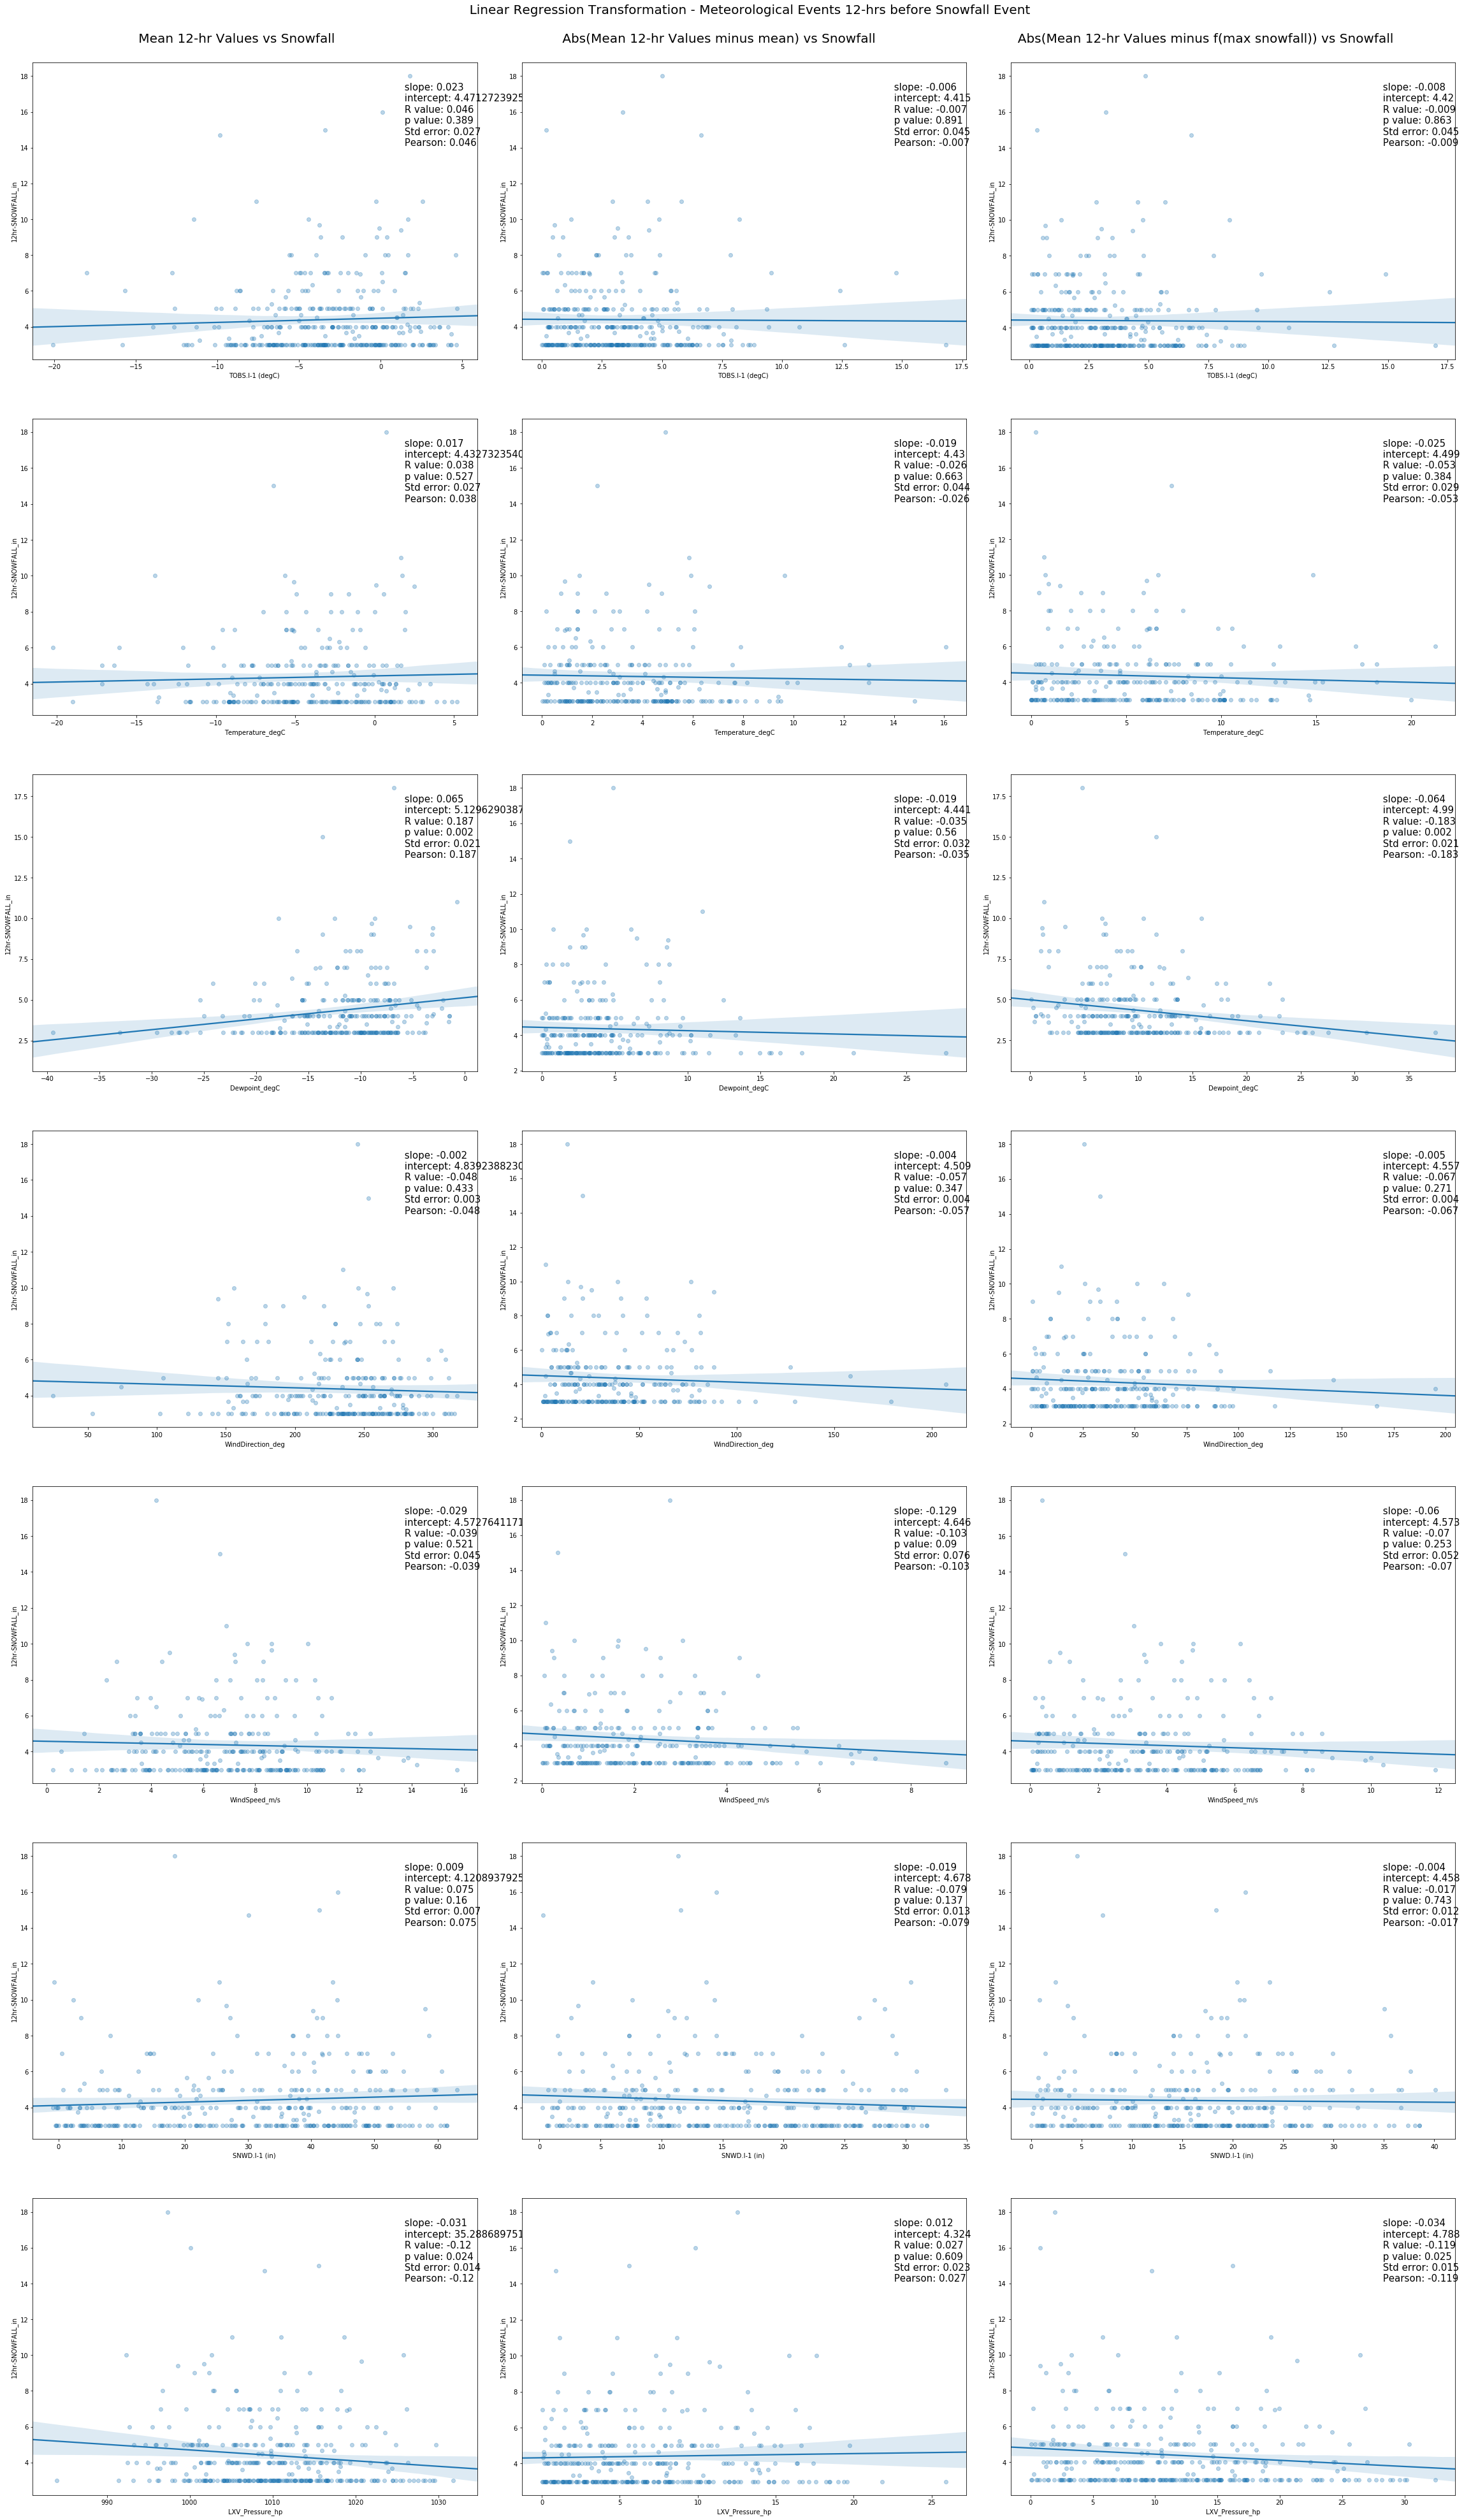

In [7]:
#shift = asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()]['TOBS.I-1 (degC) ']
#abs_diff = abs(asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()]['TOBS.I-1 (degC) ']-shift)

fig = plt.figure(figsize=(40,127))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle("%100s \n\n %50s %100s %90s" % ("Linear Regression Transformation - Meteorological Events 12-hrs before Snowfall Event", "Mean 12-hr Values vs Snowfall" , "Abs(Mean 12-hr Values minus mean) vs Snowfall", "Abs(Mean 12-hr Values minus f(max snowfall)) vs Snowfall") , fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.97)



snf_df = asos_snotel_df['12hr-SNOWFALL_in'].resample('12H').last()
snf_df[snf_df<3] = np.NaN

#yy = (asos_snotel_df['12hr-SNOWFALL_in']>=3)
#snf_df = asos_snotel_df['12hr-SNOWFALL_in'][yy]

#print(snf_df)



keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp']

for k in range(len(keys)):
    
    
    xx_df = None
    

    xx_df = asos_snotel_df[keys[k]].shift(+12).resample('12H').mean()
    
    #print(np.isnan(snf_df))
    
    subtra2_df = xx_df[~np.isnan(snf_df)].mean()
    subtra3_df = asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()][keys[k]]
    
    
    #yy=  asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmedian()][keys[k]]
    abs_diff1_df = xx_df
    abs_diff2_df = abs(xx_df- subtra2_df)
    abs_diff3_df = abs(xx_df- subtra3_df)##abs(xx_df) - delta2_df
    
    #print(abs_diff1_df.dropna())
    
    idx1 = np.isfinite(abs_diff1_df) & np.isfinite(snf_df)
    idx2 = np.isfinite(abs_diff2_df) & np.isfinite(snf_df)
    idx3 = np.isfinite(abs_diff2_df) & np.isfinite(snf_df)
    
    pearson1, pv1 = pearsonr(abs_diff1_df[idx1], snf_df[idx1])
    pearson2, pv2 = pearsonr(abs_diff2_df[idx2], snf_df[idx2])
    pearson3, pv2 = pearsonr(abs_diff3_df[idx3], snf_df[idx3])
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(abs_diff1_df[idx1], snf_df[idx1])
    slope2, intercept2, r_value2, p_value2, std_err2= linregress(abs_diff2_df[idx2], snf_df[idx2])
    slope3, intercept3, r_value3, p_value3, std_err3= linregress(abs_diff3_df[idx3], snf_df[idx3])

    


   
    plt.subplot(len(keys)*2,3,3*k+1)
    sns.regplot(abs_diff1_df[idx1], snf_df[idx1], scatter_kws={'alpha':0.3})
      

    plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,13)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    plt.subplot(len(keys)*2,3,3*k+2)
    
    sns.regplot(abs_diff2_df[idx2], snf_df[idx2], scatter_kws={'alpha':0.3})
    
    plt.annotate(' slope: ' + str(round(slope2,3)) +
                 '\n intercept: ' + str(round(intercept2,3)) + 
                 '\n R value: ' + str(round(r_value2,3)) +  
                 '\n p value: ' + str(round(p_value2,3)) + 
                 '\n Std error: ' + str(round(std_err2,3)) +
                 '\n Pearson: ' + str(round(pearson2,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    plt.subplot(len(keys)*2,3,3*k+3)
    
    sns.regplot(abs_diff3_df[idx3], snf_df[idx3], scatter_kws={'alpha':0.3})
    
    plt.annotate(' slope: ' + str(round(slope3,3)) +
                 '\n intercept: ' + str(round(intercept3,3)) + 
                 '\n R value: ' + str(round(r_value3,3)) +  
                 '\n p value: ' + str(round(p_value3,3)) + 
                 '\n Std error: ' + str(round(std_err3,3)) +
                 '\n Pearson: ' + str(round(pearson3,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    
    
 
plt.show()


### Linear Regression Transformation - Meteorological Events 24-hr Before Snowfall Event

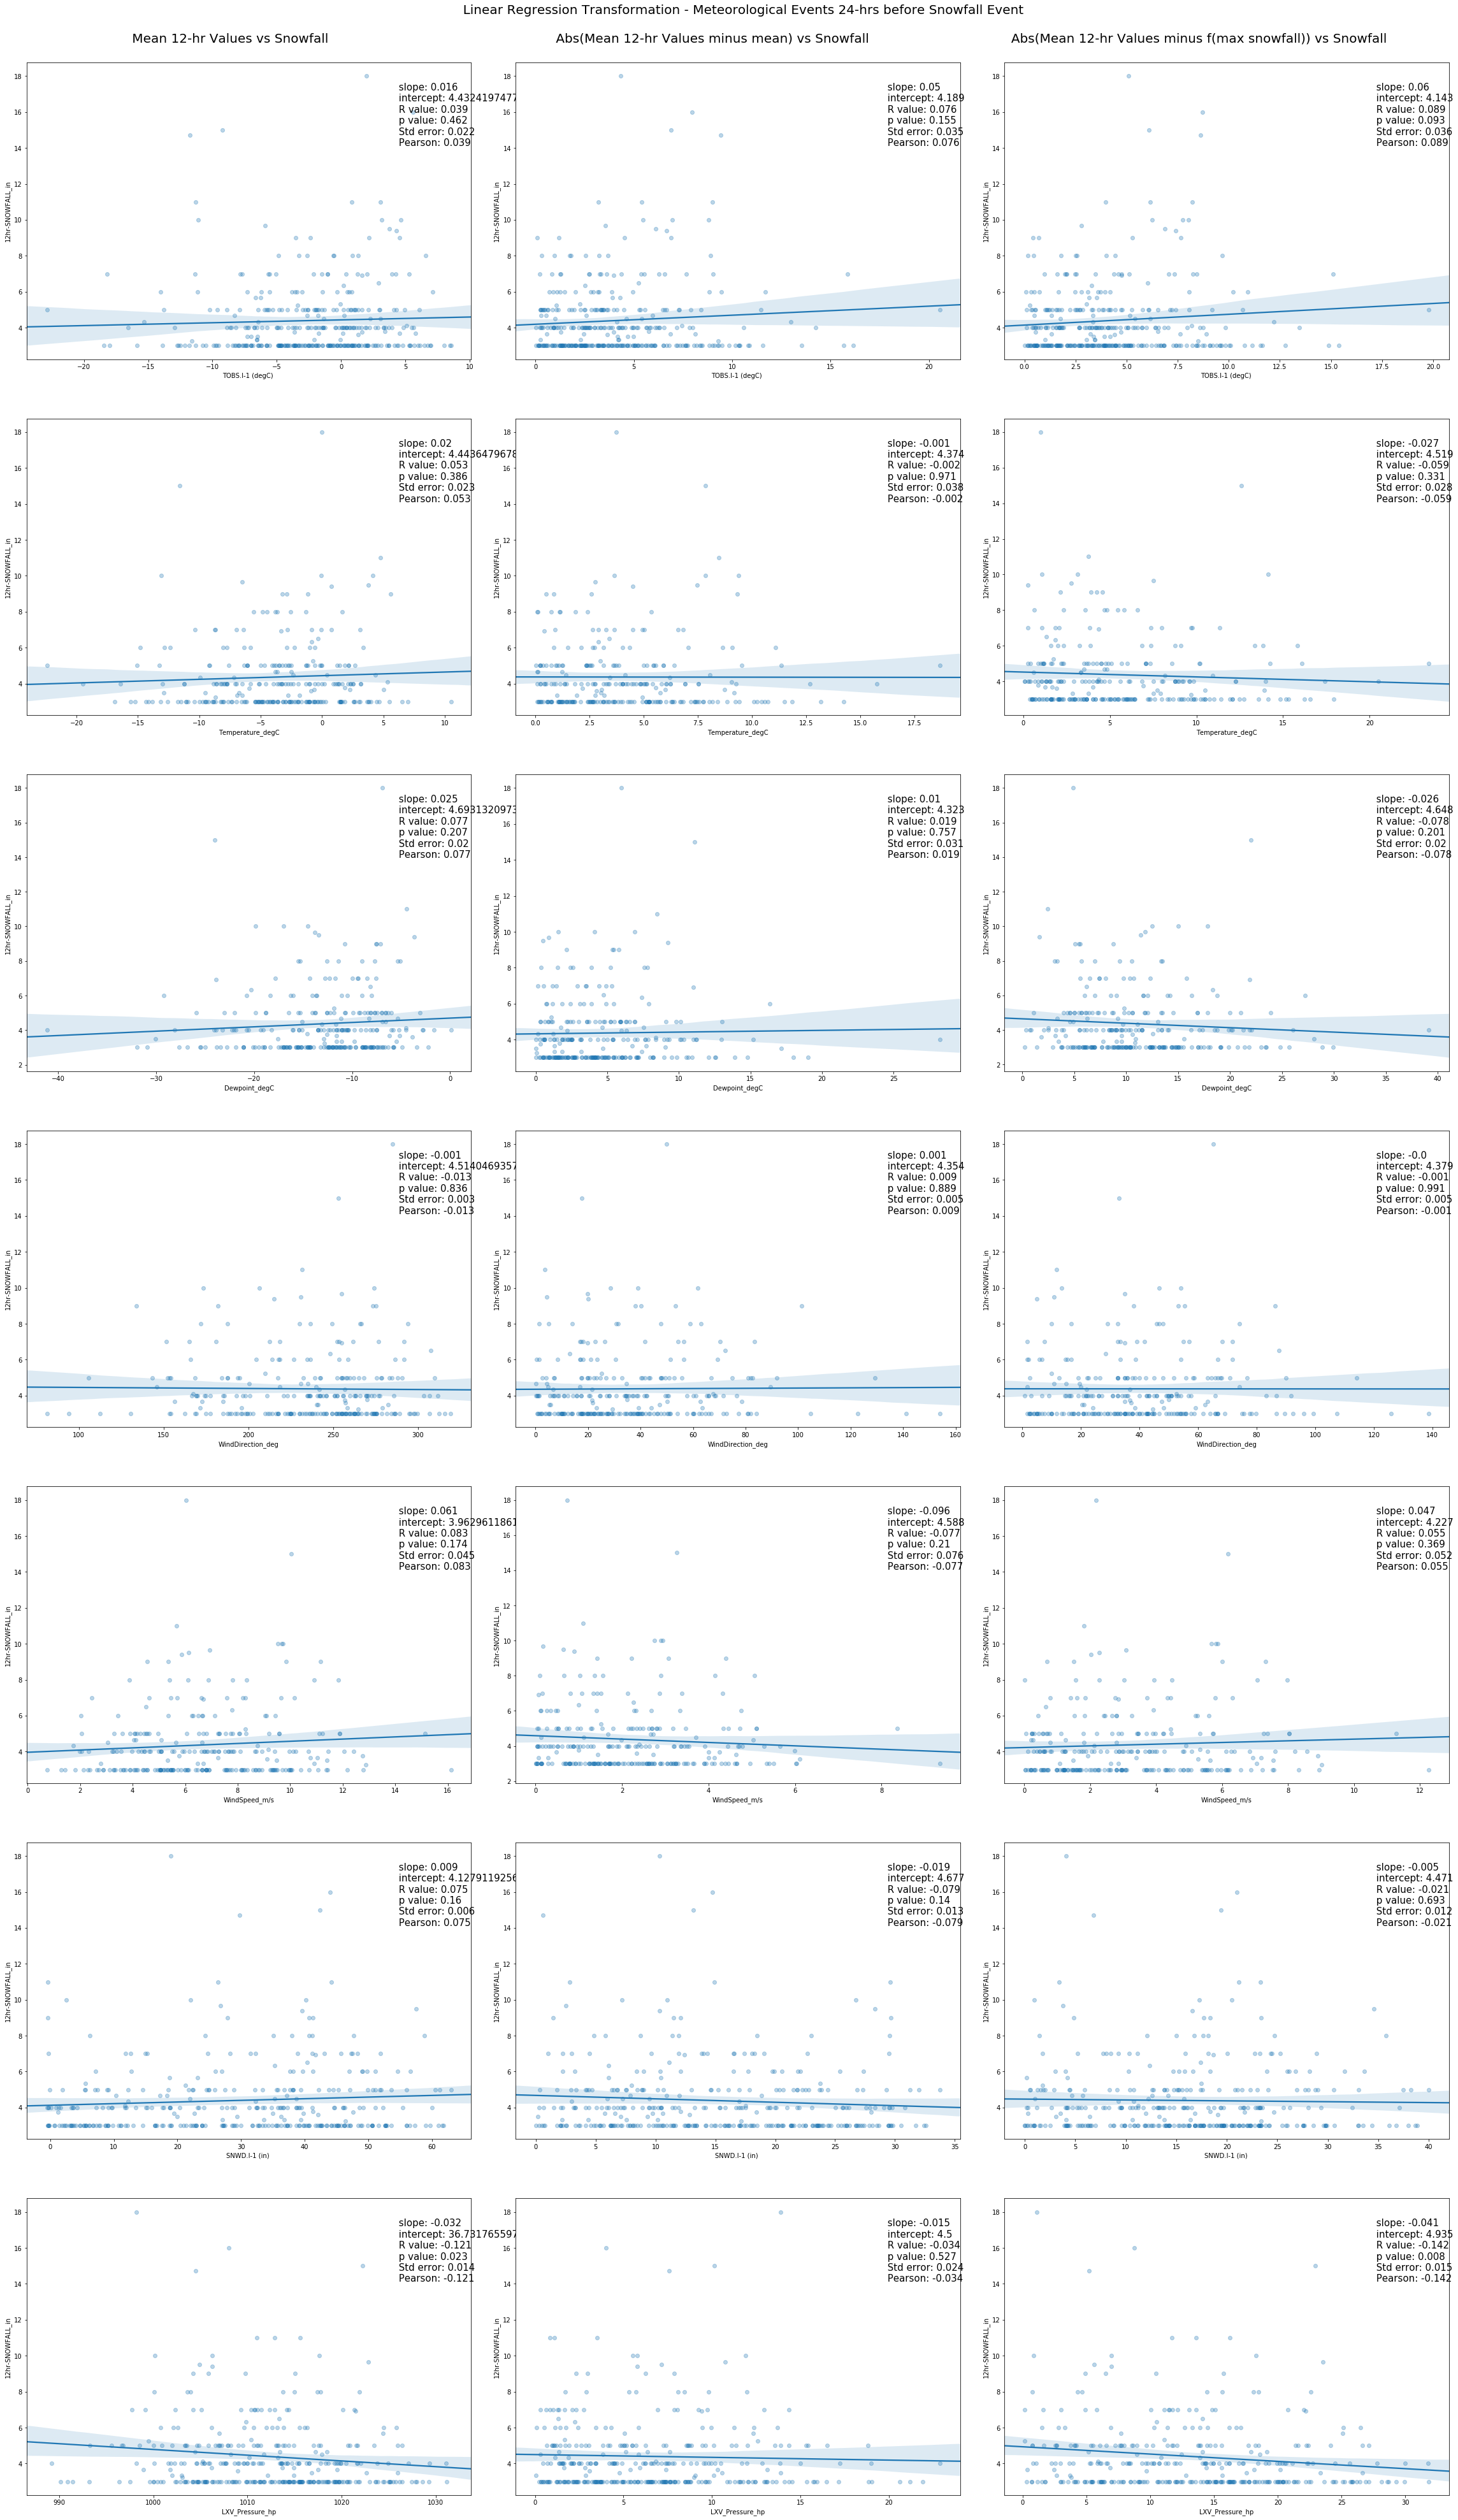

In [8]:
#shift = asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()]['TOBS.I-1 (degC) ']
#abs_diff = abs(asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()]['TOBS.I-1 (degC) ']-shift)

fig = plt.figure(figsize=(40,127))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle("%100s \n\n %50s %100s %90s" % ("Linear Regression Transformation - Meteorological Events 24-hrs before Snowfall Event", "Mean 12-hr Values vs Snowfall" , "Abs(Mean 12-hr Values minus mean) vs Snowfall", "Abs(Mean 12-hr Values minus f(max snowfall)) vs Snowfall") , fontsize = 20)
fig.tight_layout()
fig.tight_layout()
fig.subplots_adjust(top=0.97)



snf_df = asos_snotel_df['12hr-SNOWFALL_in'].resample('12H').last()
snf_df[snf_df<3] = np.NaN

#yy = (asos_snotel_df['12hr-SNOWFALL_in']>=3)
#snf_df = asos_snotel_df['12hr-SNOWFALL_in'][yy]

#print(snf_df)



keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp']

for k in range(len(keys)):
    
    
    xx_df = None
    

    xx_df = asos_snotel_df[keys[k]].shift(+24).resample('12H').mean()
    
    #print(np.isnan(snf_df))
    
    subtra2_df = xx_df[~np.isnan(snf_df)].mean()
    subtra3_df = asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmax()][keys[k]]
    
    
    #yy=  asos_snotel_df.loc[asos_snotel_df['12hr-SNOWFALL_in'].idxmedian()][keys[k]]
    abs_diff1_df = xx_df
    abs_diff2_df = abs(xx_df- subtra2_df)
    abs_diff3_df = abs(xx_df- subtra3_df)##abs(xx_df) - delta2_df
    
    #print(abs_diff1_df.dropna())
    
    idx1 = np.isfinite(abs_diff1_df) & np.isfinite(snf_df)
    idx2 = np.isfinite(abs_diff2_df) & np.isfinite(snf_df)
    idx3 = np.isfinite(abs_diff2_df) & np.isfinite(snf_df)
    
    pearson1, pv1 = pearsonr(abs_diff1_df[idx1], snf_df[idx1])
    pearson2, pv2 = pearsonr(abs_diff2_df[idx2], snf_df[idx2])
    pearson3, pv2 = pearsonr(abs_diff3_df[idx3], snf_df[idx3])
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(abs_diff1_df[idx1], snf_df[idx1])
    slope2, intercept2, r_value2, p_value2, std_err2= linregress(abs_diff2_df[idx2], snf_df[idx2])
    slope3, intercept3, r_value3, p_value3, std_err3= linregress(abs_diff3_df[idx3], snf_df[idx3])

    


   
    plt.subplot(len(keys)*2,3,3*k+1)
    sns.regplot(abs_diff1_df[idx1], snf_df[idx1], scatter_kws={'alpha':0.3})
      

    plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,13)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    plt.subplot(len(keys)*2,3,3*k+2)
    
    sns.regplot(abs_diff2_df[idx2], snf_df[idx2], scatter_kws={'alpha':0.3})
    
    plt.annotate(' slope: ' + str(round(slope2,3)) +
                 '\n intercept: ' + str(round(intercept2,3)) + 
                 '\n R value: ' + str(round(r_value2,3)) +  
                 '\n p value: ' + str(round(p_value2,3)) + 
                 '\n Std error: ' + str(round(std_err2,3)) +
                 '\n Pearson: ' + str(round(pearson2,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    plt.subplot(len(keys)*2,3,3*k+3)
    
    sns.regplot(abs_diff3_df[idx3], snf_df[idx3], scatter_kws={'alpha':0.3})
    
    plt.annotate(' slope: ' + str(round(slope3,3)) +
                 '\n intercept: ' + str(round(intercept3,3)) + 
                 '\n R value: ' + str(round(r_value3,3)) +  
                 '\n p value: ' + str(round(p_value3,3)) + 
                 '\n Std error: ' + str(round(std_err3,3)) +
                 '\n Pearson: ' + str(round(pearson3,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=15)
    
    
    
 
plt.show()


# Pressure Drops vs Snowfall


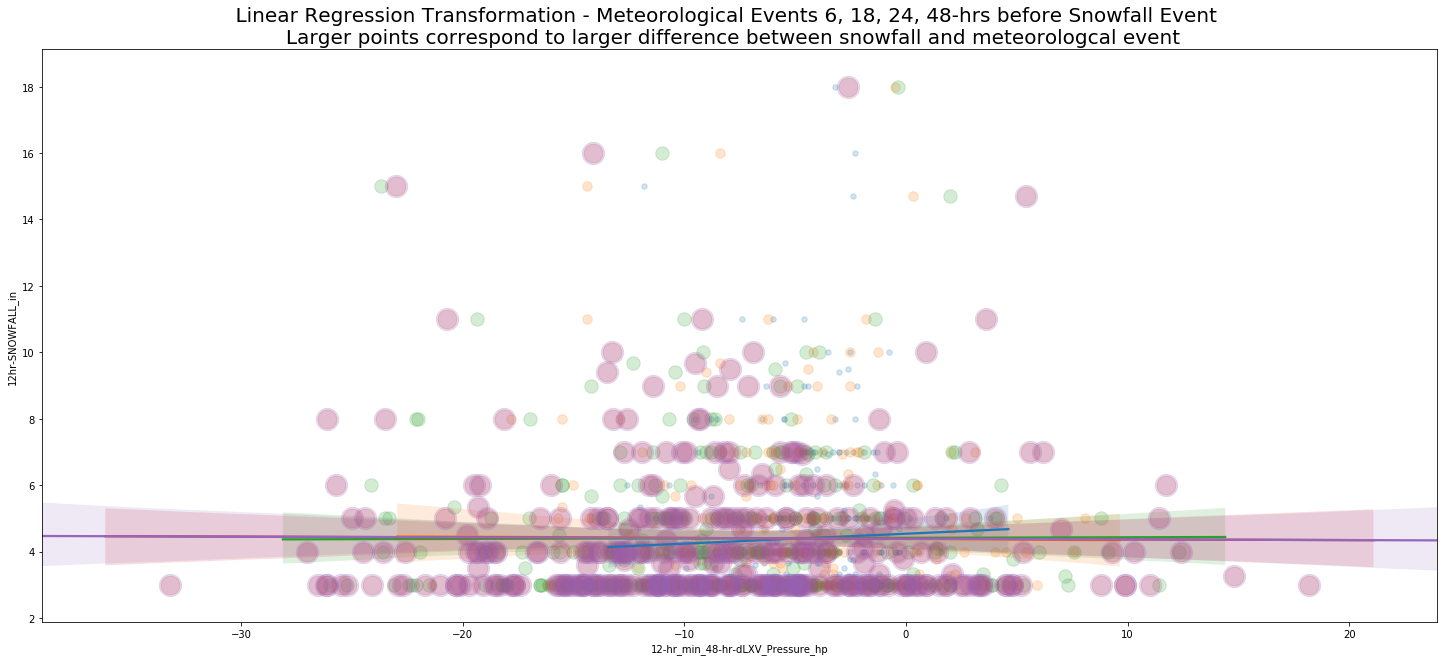

In [9]:


asos_snotel_df['1-hr-dLXV_Pressure_hp'] = asos_snotel_df['LXV_Pressure_hp']-asos_snotel_df['LXV_Pressure_hp'].shift(+1)
asos_snotel_df['3-hr-dLXV_Pressure_hp'] = asos_snotel_df['LXV_Pressure_hp']-asos_snotel_df['LXV_Pressure_hp'].shift(+3)
asos_snotel_df['6-hr-dLXV_Pressure_hp'] = asos_snotel_df['LXV_Pressure_hp']-asos_snotel_df['LXV_Pressure_hp'].shift(+6)
asos_snotel_df['12-hr-dLXV_Pressure_hp'] = asos_snotel_df['LXV_Pressure_hp']-asos_snotel_df['LXV_Pressure_hp'].shift(+12)
asos_snotel_df['18-hr-dLXV_Pressure_hp'] = asos_snotel_df['LXV_Pressure_hp']-asos_snotel_df['LXV_Pressure_hp'].shift(+18)
asos_snotel_df['24-hr-dLXV_Pressure_hp'] = asos_snotel_df['LXV_Pressure_hp']-asos_snotel_df['LXV_Pressure_hp'].shift(+24)
asos_snotel_df['48-hr-dLXV_Pressure_hp'] = asos_snotel_df['LXV_Pressure_hp']-asos_snotel_df['LXV_Pressure_hp'].shift(+48)


asos_snotel_df['12-hr_max_1-hr-dLXV_Pressure_hp'] = asos_snotel_df['1-hr-dLXV_Pressure_hp'].resample('12H').max()
asos_snotel_df['12-hr_min_1-hr-dLXV_Pressure_hp'] = asos_snotel_df['1-hr-dLXV_Pressure_hp'].resample('12H').min()
asos_snotel_df['12-hr_max_3-hr-dLXV_Pressure_hp'] = asos_snotel_df['3-hr-dLXV_Pressure_hp'].resample('12H').max()
asos_snotel_df['12-hr_min_3-hr-dLXV_Pressure_hp'] = asos_snotel_df['3-hr-dLXV_Pressure_hp'].resample('12H').min()
asos_snotel_df['12-hr_max_6-hr-dLXV_Pressure_hp'] = asos_snotel_df['6-hr-dLXV_Pressure_hp'].resample('12H').max()
asos_snotel_df['12-hr_min_6-hr-dLXV_Pressure_hp'] = asos_snotel_df['6-hr-dLXV_Pressure_hp'].resample('12H').min()
asos_snotel_df['12-hr_max_12-hr-dLXV_Pressure_hp'] = asos_snotel_df['12-hr-dLXV_Pressure_hp'].resample('12H').max()
asos_snotel_df['12-hr_min_12-hr-dLXV_Pressure_hp'] = asos_snotel_df['12-hr-dLXV_Pressure_hp'].resample('12H').min()
asos_snotel_df['12-hr_max_18-hr-dLXV_Pressure_hp'] = asos_snotel_df['18-hr-dLXV_Pressure_hp'].resample('12H').max()
asos_snotel_df['12-hr_min_18-hr-dLXV_Pressure_hp'] = asos_snotel_df['18-hr-dLXV_Pressure_hp'].resample('12H').min()
asos_snotel_df['12-hr_max_24-hr-dLXV_Pressure_hp'] = asos_snotel_df['24-hr-dLXV_Pressure_hp'].resample('12H').max()
asos_snotel_df['12-hr_min_24-hr-dLXV_Pressure_hp'] = asos_snotel_df['24-hr-dLXV_Pressure_hp'].resample('12H').min()
asos_snotel_df['12-hr_max_48-hr-dLXV_Pressure_hp'] = asos_snotel_df['24-hr-dLXV_Pressure_hp'].resample('12H').max()
asos_snotel_df['12-hr_min_48-hr-dLXV_Pressure_hp'] = asos_snotel_df['24-hr-dLXV_Pressure_hp'].resample('12H').min()

#print(asos_snotel_df['12-hr_max_1-hr-dLXV_Pressure_hp'].describe())
#print(asos_snotel_df.head())

fig = plt.figure(figsize=(25,10))

fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle("%100s \n %90s" % ("Linear Regression Transformation - Meteorological Events 6, 18, 24, 48-hrs before Snowfall Event", "Larger points correspond to larger difference between snowfall and meteorologcal event") , fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)


#ax1 = plt.subplots(1, 1)
idx1 = np.isfinite(asos_snotel_df['12-hr_max_6-hr-dLXV_Pressure_hp']) & np.isfinite(snf_df)
idx2= np.isfinite(asos_snotel_df['12-hr_max_12-hr-dLXV_Pressure_hp']) & np.isfinite(snf_df)
idx3 = np.isfinite(asos_snotel_df['12-hr_max_18-hr-dLXV_Pressure_hp']) & np.isfinite(snf_df)
idx4 = np.isfinite(asos_snotel_df['12-hr_max_24-hr-dLXV_Pressure_hp']) & np.isfinite(snf_df)
idx5 = np.isfinite(asos_snotel_df['12-hr_max_48-hr-dLXV_Pressure_hp']) & np.isfinite(snf_df)
    #idx2 = np.isfinite(abs_diff2_df) & np.isfinite(snf_df)
    #idx3 = np.isfinite(abs_diff2_df) & np.isfinite(snf_df)
    
pearson1, pv1 = pearsonr(asos_snotel_df['12-hr_max_12-hr-dLXV_Pressure_hp'][idx1], snf_df[idx1])
   # pearson2, pv2 = pearsonr(abs_diff2_df[idx2], snf_df[idx2])
    #pearson3, pv2 = pearsonr(abs_diff3_df[idx3], snf_df[idx3])
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(asos_snotel_df['12-hr_max_12-hr-dLXV_Pressure_hp'][idx1], snf_df[idx1])
    #slope2, intercept2, r_value2, p_value2, std_err2= linregress(abs_diff2_df[idx2], snf_df[idx2])
    #slope3, intercept3, r_value3, p_value3, std_err3= linregress(abs_diff3_df[idx3], snf_df[idx3])
ax1 = sns.regplot(asos_snotel_df['12-hr_min_6-hr-dLXV_Pressure_hp'][idx1], snf_df[idx1], scatter_kws={'alpha':0.2, 's':30, "label": "6-hr"})
ax1 = sns.regplot(asos_snotel_df['12-hr_min_12-hr-dLXV_Pressure_hp'][idx2], snf_df[idx2], scatter_kws={'alpha':0.2, 's':90, "label": "12-hr"})
ax1 =  sns.regplot(asos_snotel_df['12-hr_min_18-hr-dLXV_Pressure_hp'][idx3], snf_df[idx3], scatter_kws={'alpha':0.2, 's':180, "label": "18-hr"})
ax1 = sns.regplot(asos_snotel_df['12-hr_min_24-hr-dLXV_Pressure_hp'][idx4], snf_df[idx4], scatter_kws={'alpha':0.2, 's':360, "label": "24-hr"})
ax1 = sns.regplot(asos_snotel_df['12-hr_min_48-hr-dLXV_Pressure_hp'][idx5], snf_df[idx5], scatter_kws={'alpha':0.2, 's':500, "label": "48-hr"})
#sns.regplot(asos_snotel_df['12-hr_min_12-hr-dLXV_Pressure_hp'][idx1], snf_df[idx1], scatter_kws={'alpha':0.1, })




In [10]:
print(asos_snotel_df['12-hr_max_1-hr-dLXV_Pressure_hp'].describe())
print(asos_snotel_df.head())

fig = plt.figure(figsize=(50,10))
asos_snotel_df['1-hr-dLXV_Pressure_hp'].plot(linestyle='None',  marker = ".", markersize = 4, alpha = 0.5)
asos_snotel_df['3-hr-dLXV_Pressure_hp'].plot(linestyle='None',  marker = ".", markersize = 4, alpha = 0.5)

plt.show()

fig = plt.figure(figsize=(50,10))
asos_snotel_df['1-hr-dLXV_Pressure_hp']['01-01-2012':'01-02-2012'].plot(linestyle='None',  marker = ".", markersize = 14, alpha = 0.5)
#asos_snotel_df['3-hr-dLXV_Pressure_hp']['01-01-2012':'01-02-2012'].plot(linestyle='None',  marker = ".", markersize = 14, alpha = 0.5)
asos_snotel_df['LXV_Pressure_hp']['01-01-2012':'01-02-2012'].plot(marker = ".", alpha = 0.5, secondary_y = True)

plt.show()

print(asos_snotel_df.loc[:,['LXV_Pressure_hp','1-hr-dLXV_Pressure_hp']]['12-31-2010':'01-02-2012'])
#print(asos_snotel_df['LXV_Pressure_hp']['01-01-2012':'01-02-2012'], asos_snotel_df['3-hr-dLXV_Pressure_hp']['01-01-2012':'01-02-2012'])



   
    plt.subplot(len(keys)*2,3,3*k+1)
    sns.regplot(abs_diff1_df[idx1], snf_df[idx1], scatter_kws={'alpha':0.3})

IndentationError: unexpected indent (<ipython-input-10-74f230b1d8b0>, line 23)